## Contrastive learning example


## Demo goal: species-level embeddings for ESKAPEe with curriculum + contrastive learning

This notebook is a compact, end-to-end demo of **metric-learning style fine-tuning for genomic sequence embeddings**.

We start from the ESKAPEE pathogen dataset, slice genomes/contigs into fixed-length segments, and fine-tune a ProkBERT encoder with a **CurricularFace-style classification head**. The key idea is to train in **cosine (angular) space**: embeddings and class prototypes are normalized, logits are scaled, and an angular margin is applied so the model is explicitly encouraged to build **tight within-class clusters** and **clear between-class separation**. The “curriculum” comes from the head itself, which progressively focuses training on harder examples as the representation improves.

To make the effect tangible, we visualize embeddings with **UMAP** before and after a short training run. The goal is not to maximize accuracy in this toy setting, but to show how curricular metric learning reshapes the embedding space into something that is immediately useful for downstream tasks like clustering, retrieval, and lightweight classifiers.


## Setting Up the Environment

While ProkBERT can operate on CPUs, leveraging GPUs significantly accelerates the process. Google Colab offers free GPU usage making it an ideal platform for trying and experimenting with ProkBERT models.



In [ ]:
!pip install git+https://github.com/nbrg-ppcu/prokbert.git --quiet


In [1]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from prokbert.sequtils import *
from prokbert.training_utils import *
from prokbert.models import ProkBertForCurricularClassification
from prokbert.tokenizer import LCATokenizer
from prokbert.curriculum_utils import compute_umap_for_dataset
from datasets import Dataset, load_dataset, ClassLabel
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from os.path import join
import os

REPO_ID = "neuralbioinfo/eskapee"
MODEL_NAME = "neuralbioinfo/prokbert-mini-long"

/opt/mamba/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Enabling and testing the GPU (if you are using google colab)

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [2]:
# Check if CUDA (GPU support) is available
if not torch.cuda.is_available():
    raise SystemError('GPU device not found')
else:
    device_name = torch.cuda.get_device_name(0)
    print(f'Found GPU at: {device_name}')
num_cores = os.cpu_count()
print(f'Number of available CPU cores: {num_cores}')


Found GPU at: NVIDIA A100-SXM4-40GB
Number of available CPU cores: 64


## Prepearing the dataset

### Load the dataset + encode `assembly` as a numeric label

In this cell we pull `neuralbioinfo/eskapee` from the Hugging Face Hub and make the **assembly accession** a clean training label.

What we do:
- download the dataset (`split="train"`)
- create `label_id` by class-encoding `assembly` (integer IDs, stable mapping)
- keep the original `assembly` string around for readability and plotting
- print a quick top-10 label count table to confirm everything looks sensible


In [3]:
# 1) Load dataset
ds = load_dataset(REPO_ID, split="train")

ds = ds.add_column("assembly_label", ds["assembly"])
ds = ds.class_encode_column("assembly_label")          # now `assembly_label` is an integer-backed ClassLabel
ds = ds.rename_column("assembly_label", "label_id")    # trainer-friendly name

# 4) Extract mappings (id2label / label2id)
label_feature = ds.features["label_id"]
id2label = dict(enumerate(label_feature.names))
label2id = {name: i for i, name in id2label.items()}

print(f"Number of assembly labels: {len(id2label)}")



Number of assembly labels: 6


## In this section we are going to perform the segmentation and the basic dataset preprocessing



In [5]:
# Converting the dataset into a pandas dataframe for further dataprocessing
seed = 42
test_size = 0.10

sequences = ds.to_pandas()
max_length = 512
lut_cols = ["sequence_id", "label_id"]


print("[prepare_dataset] Running segmentation")
segmentation_params = {
    "max_length": max_length,
    "min_length": int(max_length * 0.5),
    "type": "contiguous",
}
raw_segment_df = segment_sequences(
    sequences, segmentation_params, AsDataFrame=True
)
print(f"[prepare_dataset] Number of segments: {len(raw_segment_df)}")


for extra in ["assembly", "taxon", "taxon_short", "taxon_name"]:
    if extra in sequences.columns and extra not in lut_cols:
        lut_cols.append(extra)
        
label_lut = sequences[lut_cols].drop_duplicates(subset=["sequence_id"])
if "sequence_id" not in raw_segment_df.columns:
    raise ValueError(
        f"`raw_segment_df` has no `sequence_id` column. Available columns: {raw_segment_df.columns.tolist()}"
    )

raw_segment_df = raw_segment_df.merge(
    label_lut,
    on="sequence_id",
    how="left",
    validate="many_to_one",
)
raw_segment_df = raw_segment_df.sample(frac=1.0)
raw_segment_df["label_id"] = raw_segment_df["label_id"].astype("int64")
hf_dataset = Dataset.from_pandas(raw_segment_df, preserve_index=False)
hf_dataset = hf_dataset.rename_column("label_id", "labels")

split = hf_dataset.train_test_split(test_size=test_size, seed=seed, shuffle=True)
train_ds = split["train"]
test_ds = split["test"]




2026-01-26 15:01:08,796 - INFO - Checking input DataFrame!
2026-01-26 15:01:08,797 - INFO - Checking input sequence_id is valid primary key in the DataFrame


[prepare_dataset] Running segmentation
[prepare_dataset] Number of segments: 51385


## Modell loading and definitions


### What these curricular parameters do

- `curricular_num_labels`  
  How many classes you have (here: the number of assemblies you encoded). This sets the size of the class weight matrix used by the CurricularFace head.

- `curricular_face_m` (margin)  
  The **angular margin** applied to the target class in cosine space. Larger values enforce stricter separation between classes (can improve discrimination, but too large may make training unstable).

- `curricular_face_s` (scale)  
  A **logit scaling factor** for cosine similarities. Without scaling, cosine logits are small and gradients can be weak; `s` restores a useful gradient magnitude. Typical values are 16–64.

- `classification_dropout_rate`  
  Dropout applied in the classification stack to reduce overfitting.

- `curriculum_hidden_size`  
  The dimensionality used by the model’s embedding/projection feeding the CurricularFace head (often 128). This is the representation you typically visualize with UMAP and reuse for retrieval/clustering.

- `id2label`, `label2id`  
  Mappings for nice model metadata (readable labels in logs/outputs) and consistent class ordering.

- `torch_dtype`  
  Controls model weights dtype. Leave as default (`None`) unless you intentionally run fp16/bf16.


In [6]:
curricular_face_m = 0.5          # angular margin (typical range ~0.2–0.6)
curricular_face_s = 64.0         # logit scale (typical range ~16–64)
classification_dropout_rate = 0.1
curriculum_hidden_size = 128     # embedding/projection size used by the curricular head (often 128)

use_bf16 = True
model_dtype = torch.bfloat16 if use_bf16 else torch.float32


model = ProkBertForCurricularClassification.from_pretrained(
    MODEL_NAME,
    curricular_num_labels=len(id2label),
    curricular_face_m=curricular_face_m,
    curricular_face_s=curricular_face_s,
    classification_dropout_rate=classification_dropout_rate,
    curriculum_hidden_size=curriculum_hidden_size,
    torch_dtype=model_dtype,
    id2label=id2label,
    label2id=label2id,
)

tokenizer = LCATokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of ProkBertForCurricularClassification were not initialized from the model checkpoint at neuralbioinfo/prokbert-mini-long and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'curricular_face.kernel', 'curricular_face.t', 'linear.bias', 'linear.weight', 'weighting_layer.bias', 'weighting_layer.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



# Now we can do the tokenization


In [7]:
num_cores = max(1, min(os.cpu_count() or 1, 16))  


def _tokenize_fn(batch):
    tok = tokenizer(
        batch["segment"],
        padding=False,              
        truncation=True,
        max_length=max_length,
    )
    masks = tok["attention_mask"]
    # Keep labels (and any identifiers you want)
    tok["labels"] = batch["labels"]
    if "sequence_id" in batch:
        tok["sequence_id"] = batch["sequence_id"]
    if "segment_id" in batch:
        tok["segment_id"] = batch["segment_id"]
    return tok

# Drop heavy text columns after tokenization, but keep identifiers + labels
keep_cols = {"labels", "sequence_id", "segment_id"}
remove_cols = [c for c in hf_dataset.column_names if c not in keep_cols and c != "segment"]

print(f"[prepare_dataset] Tokenizing with {num_cores} CPU core(s)")
tokenized_train_ds = train_ds.map(
    _tokenize_fn,
    batched=True,
    num_proc=num_cores,
    remove_columns=remove_cols + ["segment"],  # remove raw text segment post-tokenization
    keep_in_memory=True,
    desc="Tokenize segments",
)

print(f"[prepare_dataset] Tokenizing with {num_cores} CPU core(s)")
tokenized_test_ds = test_ds.map(
    _tokenize_fn,
    batched=True,
    num_proc=num_cores,
    remove_columns=remove_cols + ["segment"],  # remove raw text segment post-tokenization
    keep_in_memory=True,
    desc="Tokenize segments",
)

    

[prepare_dataset] Tokenizing with 16 CPU core(s)


Tokenize segments (num_proc=16): 100%|██████████| 46246/46246 [00:02<00:00, 19844.89 examples/s]


[prepare_dataset] Tokenizing with 16 CPU core(s)


Tokenize segments (num_proc=16): 100%|██████████| 5139/5139 [00:01<00:00, 2750.33 examples/s]


## Checking the embeddings before the training process

Before we train anything, let’s sanity-check what the **pretrained** model already knows.

In this cell we calculate a **UMAP projection** of a random sample of segment embeddings and color points by `taxon_short`. This gives us a quick visual readout of how the representation space is organized *out of the box*.

Often you can already see that contigs/segments from different taxa are **reasonably well separated** even before fine-tuning. That baseline structure is useful: the training step that follows should mostly **tighten clusters** and improve separation for the specific labels we optimize (assemblies / taxa, depending on the setup).

### UMAP: visualize a sample of segment embeddings (colored by taxon)

Steps in this cell:
- Sample up to **2,000** tokenized segments.
- Compute embeddings and project them to **2D with UMAP**, keeping the **same row order** as the sampled dataset.
- Join metadata (`assembly`, `taxon`, `taxon_short`, `taxon_name`) for labeling.
- Plot a scatter where each dot is a segment embedding, **colored by `taxon_short`**.


/opt/mamba/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


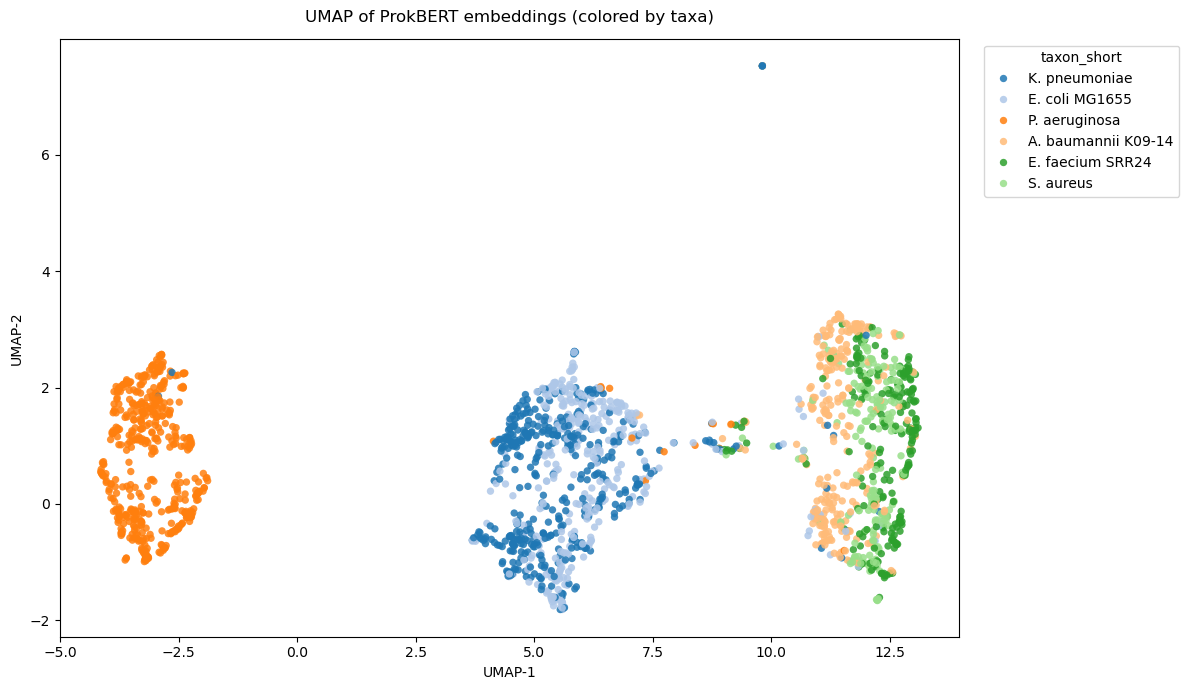

In [8]:
umap_n = 2000
umap_seed = 123

umap_ds = tokenized_test_ds.shuffle(seed=umap_seed).select(range(min(umap_n, len(tokenized_train_ds))))
coords = compute_umap_for_dataset(
    model=model,
    dataset=umap_ds,
    data_collator=data_collator,
    batch_size=128,
    seed=42,
)

# coords are aligned with umap_ds order
plot_df = pd.DataFrame(coords, columns=["umap_1", "umap_2"])
meta_cols = ["sequence_id", "segment_id", "assembly", "taxon", "taxon_short", "taxon_name"]
meta_df = hf_dataset.select_columns(meta_cols).to_pandas()

# Build plot dataframe in the same order as tokenized_test_ds_to_plot
plot_df = pd.DataFrame(coords, columns=["umap_1", "umap_2"])
plot_df["sequence_id"] = umap_ds["sequence_id"]
plot_df["segment_id"]  = umap_ds["segment_id"]
plot_df["label_id"]    = umap_ds["labels"]

# Join metadata (many-to-one should hold per segment_id; if not, switch to validate="many_to_many")
plot_df = plot_df.merge(
    meta_df,
    on=["sequence_id", "segment_id"],
    how="left",
    validate="one_to_one",
)

plt.figure(figsize=(12, 7))
ax = sns.scatterplot(
    data=plot_df,
    x="umap_1",
    y="umap_2",
    hue="taxon_short",
    s=28,          # larger dots
    alpha=0.85,
    linewidth=0,
    palette="tab20",
)

ax.set_title("UMAP of ProkBERT embeddings (colored by taxa)", pad=12)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1), title="taxon_short")
plt.tight_layout()
plt.show()



## Training 


### Training setup: two learning rates (backbone vs. curricular head)

In this cell we run a short fine-tuning job using the Hugging Face `Trainer`, with one practical twist: we use **different learning rates** for the pretrained encoder and for the new classification head.

- **Batch sizes / epochs**  
  We train with `train_batch_size=64` for `num_train_epochs=0.5`. This is intentionally small—just enough to see the embedding space move in the next UMAP plot.

- **Two parameter groups**  
  We split parameters into:
  - **Backbone** (`bert.*`): the pretrained ProkBERT encoder, updated gently with `backbone_lr=1e-5`
  - **Head** (everything else): the curricular classification components, trained faster with `head_lr=5e-4`

  This is a common fine-tuning pattern: keep the foundation model stable while letting the task-specific layers adapt quickly.

- **Trainer configuration**  
  `TrainingArguments` controls logging cadence, output directory, and precision (`bf16` is off here).  
  We pass a custom optimizer (with the two LR groups) via `optimizers=(optimizer, None)` and compute accuracy on the eval split.

After this finishes, we’ll re-run the UMAP embedding visualization to see how training reshaped the representation space.



In [9]:
train_batch_size = 64
eval_batch_size = 64
num_train_epochs = 0.5

backbone_lr = 1e-5
head_lr = 5e-4
use_bf16 = False

backbone_params = [p for n, p in model.named_parameters() if n.startswith("bert.")]
head_params = [p for n, p in model.named_parameters() if not n.startswith("bert.")]

optimizer = AdamW(
    [
        {"params": backbone_params, "lr": backbone_lr},
        {"params": head_params, "lr": head_lr},
    ],
)

training_args = TrainingArguments(
        output_dir='eskapee_example',
        overwrite_output_dir=False,
        report_to="none",
        logging_steps=20,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        bf16=use_bf16,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),
)
trainer.train()

/tmp/slurm-13188853/ipykernel_1983126/3517359654.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
2026-01-26 15:01:26,032 - WARNING - Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
20,20.090600
40,12.771900
60,13.403100
80,12.021900
100,11.481200
120,11.618800
140,10.575000
160,11.003100
180,10.585900
200,10.734400


TrainOutput(global_step=362, training_loss=11.375517955801104, metrics={'train_runtime': 26.1443, 'train_samples_per_second': 884.438, 'train_steps_per_second': 13.846, 'total_flos': 806296754257920.0, 'train_loss': 11.375517955801104, 'epoch': 0.5006915629322268})

## Final visualization

Now we repeat the exact same UMAP workflow **after training**. We reuse the same sampled dataset (`umap_ds`) and the same projection settings so the “before vs. after” comparison is meaningful.

What happens in this cell:
- We recompute embeddings with the **fine-tuned** model and project them to 2D with UMAP.
- We join back the original metadata (`assembly`, `taxon`, `taxon_short`, `taxon_name`) so we can color points by `taxon_short`.
- We plot the scatter again, using the same styling as before.

What to look for:
- Compared to the pretrained baseline, you should typically see **tighter within-class clusters** and **clearer separation between taxa**.
- In this run, classes such as *Klebsiella* and *Escherichia* that previously sat closer together become **more cleanly separated**, while points within each taxon tend to cluster more tightly.


/opt/mamba/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


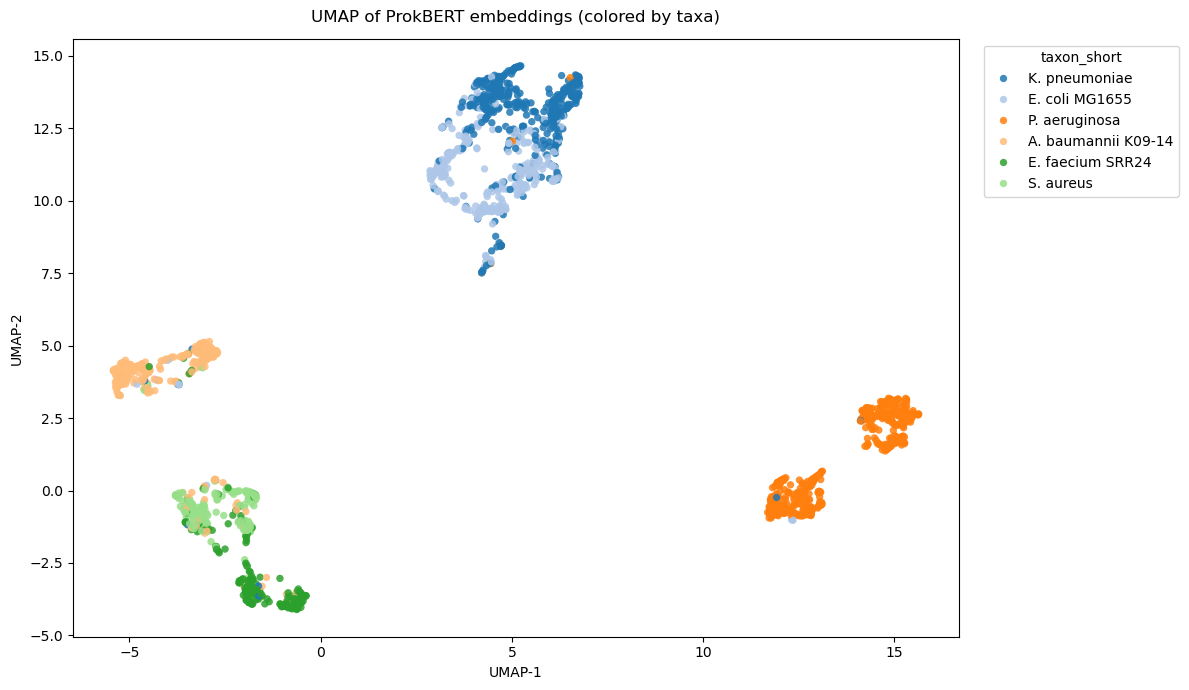

In [10]:
coords = compute_umap_for_dataset(
    model=model,
    dataset=umap_ds,
    data_collator=data_collator,
    batch_size=128,
    seed=42,
)

# coords are aligned with umap_ds order
plot_df = pd.DataFrame(coords, columns=["umap_1", "umap_2"])

meta_cols = ["sequence_id", "segment_id", "assembly", "taxon", "taxon_short", "taxon_name"]
meta_df = hf_dataset.select_columns(meta_cols).to_pandas()

# Build plot dataframe in the same order as tokenized_test_ds_to_plot
plot_df = pd.DataFrame(coords, columns=["umap_1", "umap_2"])
plot_df["sequence_id"] = umap_ds["sequence_id"]
plot_df["segment_id"]  = umap_ds["segment_id"]
plot_df["label_id"]    = umap_ds["labels"]

# Join metadata (many-to-one should hold per segment_id; if not, switch to validate="many_to_many")
plot_df = plot_df.merge(
    meta_df,
    on=["sequence_id", "segment_id"],
    how="left",
    validate="one_to_one",
)

plt.figure(figsize=(12, 7))
ax = sns.scatterplot(
    data=plot_df,
    x="umap_1",
    y="umap_2",
    hue="taxon_short",
    s=28,          # larger dots
    alpha=0.85,
    linewidth=0,
    palette="tab20",
)

ax.set_title("UMAP of ProkBERT embeddings (colored by taxa)", pad=12)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1), title="taxon_short")
plt.tight_layout()
plt.show()

